## 0 Preparing Data

We first generate images for training using ```trdg``` package. Using the code ```trdg -i 0.txt -c 20000 --output_dir data/train```.

Then we create a custom PyTorch dataset object, which has ```__len__``` and ```__getitem__``` methods. We also specify the path to the dataset and apply transform to it. The transforms are grayscaling, normalizing, and converting to tensor.

In [2]:
import torch
import os

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

dtype = torch.float32 # using float 32 throughout
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


We first define the ```MyCollator()``` class which does the padding horizontally for our images and forming a batch, which is used for ```collate_fn``` in the ```DataLoader``` object in PyTorch. There is also a function version available.

In [3]:
class MyCollator(object):
    '''Create object for padding'''
    def __call__(self,batch):
        '''
        Make the class behave like function (so can be called).
        Parameters:
            -batch: list of tuples with dictionary {'img':Image,'idx':Index}, where img is a tensor
                    of the shape C * H * W
        '''
        width = [item['img'].shape[2] for item in batch] # list of widths of images C H W
        indices = [item['idx'] for item in batch] # list of indices

        imgs = torch.ones([len(batch),batch[0]['img'].shape[0],\
            batch[0]['img'].shape[1], max(width)],dtype=dtype) # create array of ones for padding
        
        for idx, item in enumerate(batch):
            try:
                # fit image into the array generated, only altering the width
                # by replacing ones with the original but keeping extras in new
                imgs[idx,:,:,0:width[idx]] = item['img']
            except:
                print(imgs.shape)
        # Forming the batch
        item = {'img':imgs,'idx':indices}

        if 'label' in batch[0].keys():
            # if label is present then also make it a list and attach to batch
            labels = [item['label'] for item in batch]
            item['labels'] = labels
        
        return item
        

Now we define the dataset with an option of specifying the train or test data path; note how we tell ```__getitem__``` to return a dictionary of image, indices, and labels.

In [4]:
class MyDset(Dataset):
    '''Create own dataset as subclass of Dataset.'''
    def __init__(self,opt={'path':'data','imgdir':'\train'}):
        '''
        Initialize MyDset object.
        Parameters:
            -opt: a dictionary of strings indicating the location/path
        '''
        super(MyDset,self).__init__()
        
        self.path = os.path.join(opt['path'],opt['imgdir']) # To the directory storing the images

        self.images = os.listdir(self.path) # List the images name

        self.nsamp = len(self.images) 

        f = lambda x: os.path.join(self.path,x) # Join the path and the name
        self.imagepaths = list(map(f,self.images))

        self.transform = transforms.Compose([\
            transforms.Grayscale(1),\
                transforms.ToTensor(),\
                    transforms.Normalize((0.5,), (0.5,))\
                        ]) # applying transforms to the images

        # self.collate_fn = SynthCollator # specified mean to form batches
    def __len__(self):
        '''Return length of dataset.'''
        return self.nsamp
    
    def __getitem__(self, index):
        '''Get items.'''
        imagepath = self.imagepaths[index]
        name = os.path.basename(imagepath) # return final component of path
        img = Image.open(imagepath)

        if self.transform is not None: # transform images
            img = self.transform(img)

        item = {'img': img, 'idx': index} # item to return
        item['label'] = name.split('_')[0] # the word in the image # image is named in name_0x0x0x this way
        return item

This is the function version

In [5]:
def SynthCollator(batch):
        '''
        Parameters:
            -batch: list of tuples with dictionary {'img':Image,'idx':Index}, where img is a tensor
                    of the shape C * H * W
        '''
        width = [item['img'].shape[2] for item in batch] # list of widths of images C H W

        # print(max(width)) you can check if collate is working properly
        
        indices = [item['idx'] for item in batch] # list of indices

        imgs = torch.ones([len(batch),batch[0]['img'].shape[0],\
            batch[0]['img'].shape[1], max(width)],dtype=dtype) # create array of ones for padding
        
        for idx, item in enumerate(batch):
            try:
                # fit image into the array generated, only altering the width
                # by replacing ones with the original but keeping extras in new
                imgs[idx,:,:,0:width[idx]] = item['img']
            except:
                print(f'{imgs.shape} \t ERROR \n')
        # Forming the batch
        item = {'img':imgs,'idx':indices}

        if 'label' in batch[0].keys():
            # if label is present then also make it a list and attach to batch
            labels = [item['label'] for item in batch]
            item['labels'] = labels
        
        return item

We now create a ```DataLoader``` object from the dataset defined above

In [7]:
dset_train = MyDset(opt={'path':'data/','imgdir':'train'})
dset_test  = MyDset(opt={'path':'data/','imgdir':'test'})

collate_func = SynthCollator

NUM_TRAIN =int(len(dset_train)*0.9)

# Define the training and its validation dataset
loader_train = DataLoader(dset_train,\
    batch_size = 20,\
        collate_fn = collate_func,\
            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(dset_train))))

loader_val = DataLoader(dset_train,\
    batch_size = 20,\
        collate_fn=collate_func,\
            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(dset_train))))

loader_test = DataLoader(dset_test,\
    batch_size = 20,\
        collate_fn=collate_func,\
            sampler=sampler.SubsetRandomSampler(range(1000)))

We can try to print out to see if `collate_fn` is working properly, each batch is of size $20$, and the widths of the images are the same

In [8]:
for x in loader_train:
    print(x)
    print(x['img'].shape)
    break

{'img': tensor([[[[0.7412, 0.8431, 0.9216,  ..., 1.0000, 1.0000, 1.0000],
          [0.8431, 0.8980, 0.9216,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.7176, 0.7725,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.8431, 0.8039, 0.8039,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.8196, 0.7176,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 0.8745, 0.6784,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.7882, 0.7569, 0.8902,  ..., 1.0000, 1.0000, 1.0000],
          [0.8196, 0.8824, 0.9294,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.8588, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.8039, 0.9137, 0.8745,  ..., 1.0000, 1.0000, 1.0000],
          [0.8824, 0.7961, 0.7961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9294, 0.7412, 0.8275,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.9373, 0.7569, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
          [0.8118, 0.8118, 0.7647,  ..., 1.0000, 1.0000, 1.0000],
          [0.7961, 0.9294, 0.7

We try to visualize some of the images. Note the images have not been padded to the same width, as we have not applied the ```collate_fn``` until the ```DataLoader``` stage.

torch.Size([32, 72])
torch.Size([32, 43])
torch.Size([32, 32])
torch.Size([32, 98])
torch.Size([32, 130])
torch.Size([32, 48])
torch.Size([32, 113])
torch.Size([32, 84])
torch.Size([32, 79])


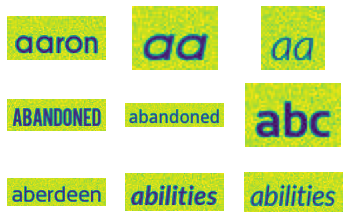

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(1,3*3+1):
    img = dset_train[i]['img'][0,:,:]
    print(img.shape)
    fig.add_subplot(3,3,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()


We will now implement the model in Pytorch as a Lightning Module.  


The network consists of consecutive convolutional layers with max-pooling layers of $2\times 2$ and $2 \times 1$; the conv layers produce feature maps as column vectors, which act as the sequential input for the RNN. (Include paper)

We first deal with the RNN, which is bidirectional and uses the LSTM structure. The code is taken from the [this repo](https://github.com/meijieru/crnn.pytorch/tree/master/models)

In [14]:
import pytorch_lightning as pl

In [10]:
class BLR(nn.Module):
    '''Implement the bidirectional LSTM RNN.'''
    def __init__(self,nIn,nHidden,nOut):
        '''
        Initialize the BLR.
        Parameters:
            -nIn: input size
            -nHidden: hidden size
            -nOut: output size
        '''
        super().__init__()
        self.rnn = nn.LSTM(nIn,nHidden,\
            bidirectional=True)
        # final FC necessary??
        self.linear = nn.Linear(2*nHidden,nOut) # bi-direction

    def forward(self,input):
        # https://discuss.pytorch.org/t/why-do-we-need-flatten-parameters-when-using-rnn-with-dataparallel/46506
        self.rnn.flatten_parameters()

        r,_ = self.rnn(input) # output of LSTM is out,(hidden,cell)
        L,N,H = r.size() # getting sequence len, batch size, and hidden size*2

        r_alt = r.view(L*N,H)
        output = self.linear(r_alt)

        output = output.view(L,N,-1) # out is now a sequence of L each term a vector of size N
        return output

We test our implementation of ```BLR```.

In [11]:
def testBLR():
    '''Test output size of BLR.'''
    model = BLR(512,16,26)
    input = torch.zeros((25,64,512)) # 100*32 image, batch_size=64, 512 final features
    output = model(input)
    return output.size()

testBLR() # Expect L*N*class

torch.Size([25, 64, 26])

Now we implement the full CRNN as in the paper. The structure is as follows:  

$3 \times 3 $ ```Conv```, $64$ feature maps  
$2 \times 2 $ ```MaxPool2D```, stride = $2$, img_size halved  

$N \times H \times W = 64 \times 16 \times 64$  

$3 \times 3 $ ```Conv```, $128$ feature maps  
$2 \times 2 $ ```MaxPool2D```, stride = $2$, img_size halved   

$N \times H \times W = 128 \times 8 \times 32$  

$3 \times 3 $ ```Conv```, $256$ feature maps  
$3 \times 3 $ ```Conv```, $256$ feature maps  (can be omitted?)

$2 \times 1 $ ```MaxPool2D```, stride = $2$, img_size halved vertically  

$N \times H \times W = 256 \times 4 \times 16$  

$3 \times 3 $ ```Conv```, $512$ feature maps    

$BatchNorm$  Layer.

$2 \times 1 $ ```MaxPool2D```, stride = $2$, img_size halved vertically  

$N \times H \times W = 512 \times 2 \times 16$  

$2 \times 2 $ ```Conv```, $512$ feature maps, img_size halved vertically 

$N \times H \times W = 512 \times 1 \times 16$  

We define a ```Conv``` layer function for convenience.

In [12]:
def myConv(ker_size=3,in_chan=1,out_chan=64,\
    nPad=1, batchNorm=False, leaky=False,label=00):
    '''
    Implement custom conv layer.
    Parameters:
        -ker_size: int, size of 
        -in_chan: int, the input size
        -out_chan: int, the output size
        -nPad: tuple or 
        -batchNorm: bool
        -maxPool: bool
        -label: to distinguish different layers
    Output:
        -A list of nn objects
    '''
    out = nn.Sequential()
    conv_layer = nn.Conv2d(in_channels=in_chan,out_channels=out_chan,\
        kernel_size=ker_size,padding=nPad,stride=1)
        
    out.add_module('conv{0}'.format(label),conv_layer)
    
    if batchNorm:
        out.add_module('bn{0}'.format(label),nn.BatchNorm2d(out_chan))
    if leaky:
        out.add_module('leaky{0}'.format(label),nn.LeakyReLU(0.2, inplace=True))
    else:
        out.add_module('relu{0}'.format(label),nn.ReLU(inplace=True))
    
    return out


Now we define the network as a `LightningModule`, including the **CTC** loss function and `forward` for testing. We use some helper functions.


In [13]:
class CRNN(pl.LightningModule):
    '''
    Implement the CRNN.
    Parameters:
        -opt: a dictionary containing the paramters
            -leaky: boolean for ReLU
            -nHidden: int for no. of RNN layers
            -nClass: int for class of characters
        opt = {'leaky':False,'nHidden':256,'nClass':26})
    '''
    def __init__(self, \
        opt = {'leaky':False,'nHidden':256,'nClass':26}):
        super().__init__()
        
        leaky = opt['leaky']
        nHidden = opt['nHidden']
        nClass = opt['nClass']

        group = nn.Sequential()

        group.add_module('conv1',myConv(leaky=leaky))
        group.add_module('mpool1',nn.MaxPool2d(2,2))

        group.add_module('conv2',myConv(3,64,128,1,leaky=leaky))
        group.add_module('mpool2',nn.MaxPool2d(2,2))

        group.add_module('conv3',myConv(3,128,256,1,leaky=leaky))
        group.add_module('mpool3',nn.MaxPool2d((2,2),(2,1),(0,1)))
        
        # # group.add_module('conv3_5',myConv(3,128,256,1,leaky=leaky))

        group.add_module('conv4',myConv(3,256,512,1,leaky=leaky,batchNorm=True))

        group.add_module('conv5',myConv(3,512,512,1,leaky=leaky,batchNorm=True))
        group.add_module('mpool5',nn.MaxPool2d((2,2),(2,1),(0,1)))

        group.add_module('conv_final',myConv(2,512,512,0,leaky=leaky,batchNorm=True)) 

        # # PyTorch does not support asymmetrical padding

        self.cnn = group

        self.rnn = nn.Sequential(BLR(512,nHidden,nHidden),\
            BLR(nHidden,nHidden,nClass))
        
    def forward(self,input):
        convolved = self.cnn(input)
        N,C,H,W = convolved.size()
        assert H==1,'Height should be 1'
        # reshaping into a sequence of length Width
        # each term is a batch of N vectors of C=512
        convolved = convolved.squeeze(2) # height is 1 so squeeze
        convolved = convolved.permute(2,0,1) # now length of seq = W, batch size N, and features C=512

        output = self.rnn(convolved)

        return output

    def training_step(self, batch, batch_idx):
        '''
        Compute and return training loss.
            Parameters:
            - batch: output of DataLoader
            - batch_idx: integer displaying the index of this batch
        '''
        criterion = nn.CTCLoss() # using CTC-Loss

        
        images, texts = batch

        # Pass through network
        convolved = self.cnn(images)
        N,C,H,W = convolved.size()
        assert H==1,'Height should be 1'
        convolved = convolved.squeeze(2)
        convolved = convolved.permute(2,0,1)
        output = self.rnn(convolved)

        # Get log_prob
        log_probs = F.log_softmax(output, dim = 2) # along final class dimension 

        T, N, C = log_probs.size()
        input_len = torch.LongTensor([T for i in range(N)])
        
        # targets, target_len = converter.encode(texts)
        # targets= targets.view(-1).contiguous()
        # loss = criterion(log_probs, targets, input_len, target_len)
        return loss
        pass
    
    

NameError: name 'pl' is not defined

We test our implementation of ```CRNN``` and various features of it.

In [17]:
def testCRNN():
    '''Test output size of CRNN.'''
    opt = {'leaky':False,'nHidden':256,'nClass':26}
    model = CRNN(opt)
    input = torch.zeros((64,1,32,128)) # 32*128 image, 1 color channel, batch_size=64, 512 final features
    output = model(input)
    return output.size()

testCRNN() # Expect L*N*class

C:\Users\yunjie wang\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([33, 64, 26])